<a href="https://colab.research.google.com/github/MatthewYancey/16-9GAN/blob/master/src/model_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16:9 Generative Model
This notebook takes images that are in a 4:3 aspect ratio and converts them to 16:9 aspect ratio.

## Imports and Parameters

In [29]:
import shutil
import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
# network parameters
BATCH_SIZE = 16
DATASET_SIZE = 1000
N_BATCHES = (DATASET_SIZE // BATCH_SIZE) * 2 # divide by two because we have two data loaders and the batch size is split between them
N_GPU = 1
N_WORKERS = 1
N_EPOCHS = 100
LEARNING_RATE = 0.0002

# image
IMG_WIDTH = 455
IMG_HEIGHT = 256
SINGLE_SIDE = int(IMG_WIDTH * 0.125)

# directories
ZIP_DIR_TRAIN = '/content/gdrive/My Drive/16:9GAN/data_out/train.zip'
ZIP_DIR_TEST = '/content/gdrive/My Drive/16:9GAN/data_out/test.zip'
IMG_DIR_TRAIN = '/content/frames/train/'
IMG_DIR_TEST = '/content/frames/test/'
LOG_DIR = '/content/gdrive/My Drive/16:9GAN/data_out/logs/model_001/'

# checkpoint type
CHECKPOINT_TYPE = 'none' # none or prev_checkpoint

In [31]:
# unzips images
shutil.unpack_archive(ZIP_DIR_TRAIN, IMG_DIR_TRAIN, 'zip')
shutil.unpack_archive(ZIP_DIR_TEST, IMG_DIR_TEST, 'zip')

In [32]:
# sets what device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and N_GPU > 0) else "cpu")
print(f'Device: {device}')

Device: cuda:0


## Helper Functions

### Apply Mask

In [34]:
# helper function for apply the mask or cutting the frame to 4:3
def apply_mask(batch, single_side=True):
    if single_side:
        batch[:, :, :, (IMG_WIDTH - SINGLE_SIDE):] = -1
        return batch

### Image Scaling

In [35]:
# helper function for converting images to a normal range
def img_scale(img_tensor, plot=False):
    min_value = img_tensor.min()
    span = img_tensor.max() - img_tensor.min()
    img_tensor = (img_tensor - min_value) / span

    # tensorboard and matplotlib take images in different formats
    if plot:
        img_tensor = img_tensor.transpose(0, 2)
        img_tensor = torch.rot90(img_tensor, -1) # fixes a rotation issue

    return img_tensor

### Checkpoint

In [36]:
def checkpoint(epoch, i, batch_counter, disc_loss, train_loss, test_loss):
    print(f'Epoch: {epoch}/{N_EPOCHS}, Batch in Epoch: {i}/{N_BATCHES}, Total Images {batch_counter * BATCH_SIZE}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    # saves everything once every epoch
    if i == 0:
        # saves loss to the tensorboard log
        writer = SummaryWriter(LOG_DIR)
        writer.add_scalar('Loss/Disc', disc_loss, batch_counter)
        writer.add_scalar('Loss/Train', train_loss, batch_counter)
        writer.add_scalar('Loss/Test', test_loss, batch_counter)

        # saves a checkpoint
        checkpoint = {'gen_state': gen.state_dict(), 
                        'gen_optimizer': optimizer_gen.state_dict(),
                        'global_disc_state': global_disc.state_dict(),
                        'global_disc_opt': optimizer_disc.state_dict()}
        torch.save(checkpoint, LOG_DIR + 'checkpoint.pt')

        # Saves an image so we can view the progression
        test_inputs = next(iter(dataloader_spotcheck))
        test_inputs = test_inputs.cuda()
        with torch.no_grad():
            image = gen(test_inputs)[1]
        image = img_scale(image)[0]
        writer.add_image(f'Epoch_{epoch}', image)




        # if this is the first epoch we save the reference images
        if epoch == 0:
            writer.add_image(f'.Reference Image', img_scale(test_inputs[0]))
            test_inputs = apply_mask(test_inputs)
            writer.add_image(f'.Reference Image Mask', img_scale(test_inputs[0]))

        # saves the epoch counter
        with open(LOG_DIR + '/itercount.txt', 'w') as f:
            f.write(str(batch_counter))
        
        writer.close()
        print('Saved checkpoint')

## Data Loaders

In [37]:
# a custom dataset class for reading in our images from the list
class ReadFromList(Dataset):

    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = Image.open(self.img_list[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image

### Training Data

In [38]:
# gets the list of images
img_list = glob.glob(IMG_DIR_TRAIN + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')
img_list = img_list[:DATASET_SIZE]

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_train.dataset)}')

Number of images: 114808
Size of dataset: 1000


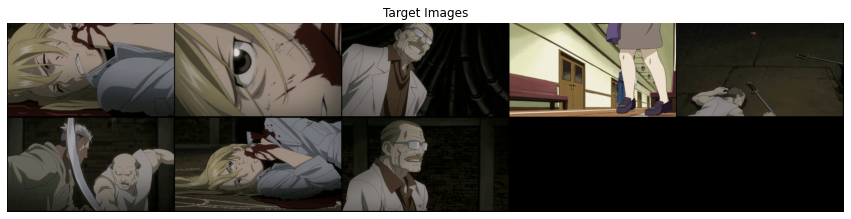

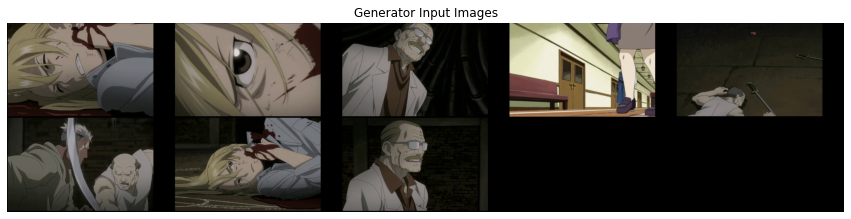

In [39]:
# Plot some training images
batch = next(iter(dataloader_train))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

batch = apply_mask(batch)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Generator Input Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

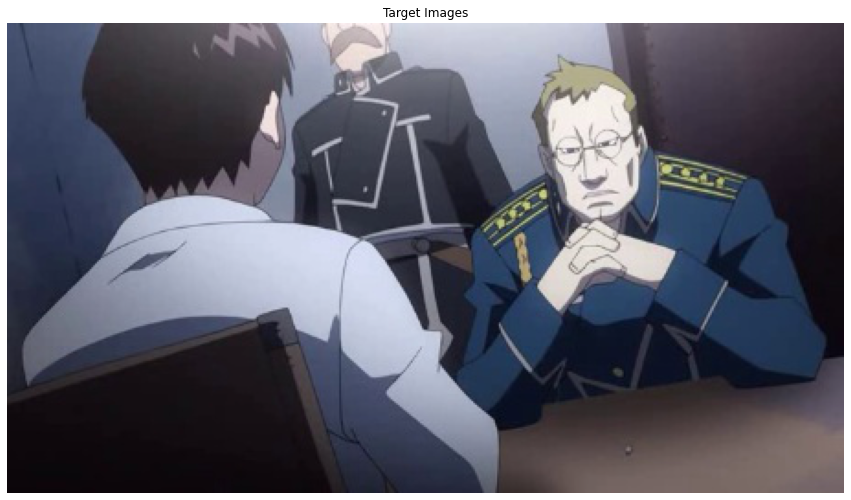

In [42]:
image = dataloader_train.dataset.__getitem__(0)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(image, padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

### Testing Data

Number of images: 36734
Size of dataset: 1000


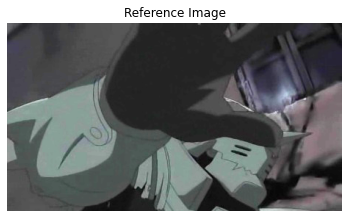

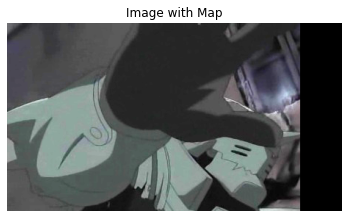

In [11]:
# gets the list of images
img_list = glob.glob(IMG_DIR_TEST + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')
img_list = img_list[:DATASET_SIZE]

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE//2, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_test.dataset)}')

# makes a dataloader for keeping the spot check image that will be on tensorboard
dataset_spotcheck = torch.utils.data.Subset(dataset, [600])
dataloader_spotcheck = torch.utils.data.DataLoader(dataset_spotcheck, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
batch = next(iter(dataloader_spotcheck))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Reference Image')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

batch = apply_mask(batch)
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Image with Map')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

## Networks

### Generartor

In [12]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.dilconv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.dilconv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.dilconv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.dilconv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv10 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.conv11 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.batch_norm3 = nn.BatchNorm2d(3)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, img):
        # encoding
        x = self.conv1(img)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch_norm128(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # dilation
        x = self.dilconv1(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv2(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv3(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        # more encoding
        x = self.conv7(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv8(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # decoding
        x = self.deconv1(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv9(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv10(x)
        x = self.batch_norm32(x)
        x = self.relu(x)

        # output
        x = self.conv11(x)
        x = self.tanh(x)

        # creates the local output and global output that is combined with the orginal image
        gen_output_local = x[:, :, :, (IMG_WIDTH - SINGLE_SIDE):]
        global_gen_output = x

        return (gen_output_local, x)

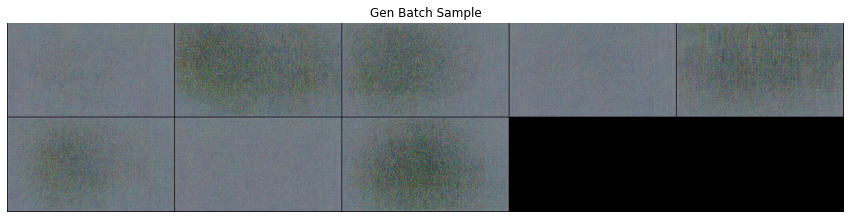

In [14]:
# checks the generator output
gen = Generator(N_GPU).to(device)
gen.apply(weights_init)

batch = next(iter(dataloader_train))
batch = apply_mask(batch)
gen_output_local, gen_output_global = gen(batch.to(device))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Gen Batch Sample')
plt.imshow(np.transpose(vutils.make_grid(gen_output_global.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

### Discriminators

#### Global Discriminator

In [15]:
class GlobalDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(GlobalDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.conv7 = nn.Conv2d(512, 1, kernel_size=5, stride=2, padding=2)

        self.batch64 = nn.BatchNorm2d(64)
        self.batch128 = nn.BatchNorm2d(128)
        self.batch256 = nn.BatchNorm2d(256)
        self.batch512 = nn.BatchNorm2d(512)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch256(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch512(x)
        x = self.relu(x)

        x = self.conv7(x)
        x = self.sigmoid(x)

        return x

## Training

### Loads Checkpoints

In [16]:
if CHECKPOINT_TYPE == 'prev_checkpoint':
    # loads the model weights
    checkpoint = torch.load(LOG_DIR + 'checkpoint.pt')
    gen.load_state_dict(checkpoint['gen_state'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOG_DIR + 'itercount.txt', 'r') as f:
        batch_counter = int(f.read())
    # moves it up one becuase it's currenlty at the last epoch we did
    batch_counter += 1

elif CHECKPOINT_TYPE == 'none':
    # remove all previous logs
    try:
        shutil.rmtree(LOG_DIR)
        print('Folders removed')
    except FileNotFoundError:
        print('No log folder found')

    batch_counter = 1

else:
    print('Failed to specify a type')

No log folder found


### Checkpoint


### Initialize the Networks

In [17]:
gen = Generator(N_GPU).to(device)
gen.apply(weights_init)

Generator(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dilconv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (dilconv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  (dilconv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
  (dilconv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(16, 16), dilation=(16, 16))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3),

In [26]:
global_disc = GlobalDiscriminator(N_GPU).to(device)
global_disc.apply(weights_init)

GlobalDiscriminator(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv5): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv6): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv7): Conv2d(512, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (batch64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

### Loss Function and Optimizer

In [27]:
loss = nn.BCELoss()
mse_loss = nn.MSELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))
optimizer_disc = optim.Adam(global_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

### Training Loop

In [28]:
batch_counter = 0

for epoch in range(N_EPOCHS):
    # gets data for the generator
    for i, batch in enumerate(dataloader_train, 0):

        gen.zero_grad()
        # passing target images to the Discriminator
        # global_disc.zero_grad()
        # disc_output = global_disc(batch.to(device))
        # error_target = loss(disc_output, torch.ones(disc_output.shape).cuda())
        # error_target.backward()

        # passes fake images to the Discriminator
        batch_mask = apply_mask(batch)
        gen_output_local, gen_output_global = gen(batch_mask.to(device))
        # disc_output = global_disc(gen_output_global.detach())
        # error_fake = loss(disc_output, torch.zeros(disc_output.shape).to(device))
        # error_fake.backward()

        # combines the errors
        # error_total = error_target + error_fake
        # optimizer_disc.step()

        # updates the generator
        # disc_output = global_disc(gen_output_global)
        # loss_gen = loss(disc_output, torch.ones(disc_output.shape).to(device))
        train_loss = mse_loss(gen_output_global, batch.to(device))
        
        # error_gen = loss_gen + loss_img_diff
        train_loss.backward()
        # error_gen.backward()
        optimizer_gen.step()

        # checkpoints and print statistics every n batches
        if i % 10 == 0:
            # gets the testing MSE
            batch = next(iter(dataloader_test))
            batch_mask = apply_mask(batch)
            with torch.no_grad():
                gen_output_local, gen_output_global = gen(batch_mask.to(device))
            test_loss = mse_loss(gen_output_global, batch.to(device))
            checkpoint(epoch, i, batch_counter, 0, train_loss.item(), test_loss.item())
        batch_counter += 1

Epoch: 37/100, Batch in Epoch: 0/124, Total Images 74000, Train Loss: 0.00, Test Loss: 0.01
Saved checkpoint
Epoch: 37/100, Batch in Epoch: 10/124, Total Images 74160, Train Loss: 0.00, Test Loss: 0.02
Epoch: 37/100, Batch in Epoch: 20/124, Total Images 74320, Train Loss: 0.01, Test Loss: 0.03
Epoch: 37/100, Batch in Epoch: 30/124, Total Images 74480, Train Loss: 0.00, Test Loss: 0.02
Epoch: 37/100, Batch in Epoch: 40/124, Total Images 74640, Train Loss: 0.01, Test Loss: 0.02
Epoch: 37/100, Batch in Epoch: 50/124, Total Images 74800, Train Loss: 0.00, Test Loss: 0.02


KeyboardInterrupt: ignored